#Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/'

#Data Preparation

Total number of headlines: 136811


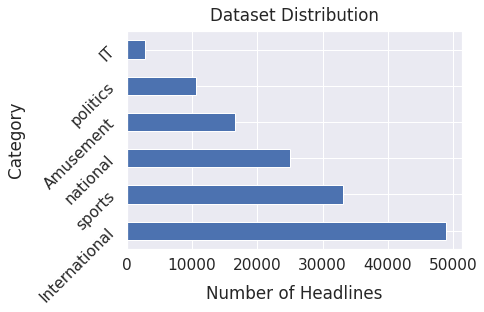

In [3]:
data = pd.read_csv(path+'headlines.csv',encoding='utf-8')
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [4]:
data.columns

Index(['headline', 'category', 'newspaper name'], dtype='object')

#Data Cleaning

In [5]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return headlines
# Apply the function into the dataframe
data['cleaned'] = data['headline'].apply(cleaning_data)  

# print some cleaned reviews from the dataset
sample_data = [2000,5000,10000,20000,30000,35000,40000,45000,50000,60000,65000,70000,75000,80000,100000]
for i in sample_data:
  print('Original: ',data.headline[i],'\nCleaned:',
           data.cleaned[i],'\n','Category:-- ',data.category[i],'\n')   

Original:  ক্ষমা চেয়েও মুক্তি পেলেন না পরিচালক গাজী মাহবুব 
Cleaned: ক্ষমা চেয়েও মুক্তি পেলেন না পরিচালক গাজী মাহবুব 
 Category:--  Amusement 

Original:  ব্র্যান্ডউইথের ব্যবহার ৮০০ জিবিপিএস ছাড়িয়ে 
Cleaned: ব্র্যান্ডউইথের ব্যবহার ৮০০ জিবিপিএস ছাড়িয়ে 
 Category:--  IT 

Original:  জামিনে মুক্তি পেলেন ছাত্রদল সভাপতি 
Cleaned: জামিনে মুক্তি পেলেন ছাত্রদল সভাপতি 
 Category:--  politics 

Original:  দ. কোরিয়ায় ১০০টি খালি কফিন পাঠিয়েছে যুক্তরাষ্ট্র 
Cleaned: দ  কোরিয়ায় ১০০টি খালি কফিন পাঠিয়েছে যুক্তরাষ্ট্র 
 Category:--  International 

Original:  ফ্লোরিডায় হামলাকারী ‘মানসিকভাবে অসুস্থ’: ট্রাম্প 
Cleaned: ফ্লোরিডায় হামলাকারী  মানসিকভাবে অসুস্থ   ট্রাম্প 
 Category:--  International 

Original:  সেরাটা দিতে পারলে সিরিজ জিতবে বাংলাদেশ: মাশরাফি 
Cleaned: সেরাটা দিতে পারলে সিরিজ জিতবে বাংলাদেশ  মাশরাফি 
 Category:--  sports 

Original:  সাকিব ফেরালেন শাই হোপকে 
Cleaned: সাকিব ফেরালেন শাই হোপকে 
 Category:--  sports 

Original:  কংগ্রেস সভাপতির পদ থেকে রাহুল গান্ধীর পদত্যাগ 
Cleaned: কংগ্রেস সভা

#Remove Low Length Data

In [6]:
# Length of each headlines
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Headlines".format(len(data)-len(dataset)),
      "\nTotal Headlines:",len(dataset))

After Cleaning: 
Removed 4098 Small Headlines 
Total Headlines: 132713


#Dataset Analysis

In [7]:
def data_summary(dataset):
    
    """
    This function will print the summary of the headlines and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.category.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.category==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.category==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.category==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)    



Class Name :  International
Number of Documents:47885
Number of Words:307354
Number of Unique Words:28710
Most Frequent Words:

নিহত	3398
না	2133
নিয়ে	1634
ট্রাম্প	1472
মার্কিন	1434
ও	1342
থেকে	1332
ভারতের	1212
যুক্তরাষ্ট্র	1208
ভারত	1192

Class Name :  sports
Number of Documents:30831
Number of Words:152852
Number of Unique Words:18581
Most Frequent Words:

বাংলাদেশ	1581
না	1122
জয়	883
বাংলাদেশের	873
শুরু	782
নিয়ে	689
সাকিব	672
ভারত	619
শেষ	603
দল	573

Class Name :  national
Number of Documents:24557
Number of Words:158042
Number of Unique Words:20710
Most Frequent Words:

না	1444
হবে	1292
ও	1215
প্রধানমন্ত্রী	1003
আজ	752
থেকে	617
কাদের	613
খালেদা	566
বিএনপি	557
নিয়ে	556

Class Name :  Amusement
Number of Documents:16067
Number of Words:98582
Number of Unique Words:16622
Most Frequent Words:

নতুন	1158
নিয়ে	1074
ও	1003
গান	683
ভিডিও	517
না	484
নাটক	469
খান	461
চলচ্চিত্র	416
আজ	412

Class Name :  politics
Number of Documents:10577
Number of Words:75657
Number of Unique Words:10398
Mos

#Summary Visualization

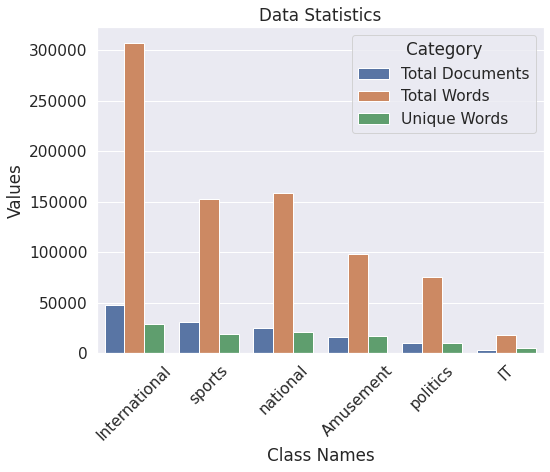

In [8]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

#Headline Length Distribution

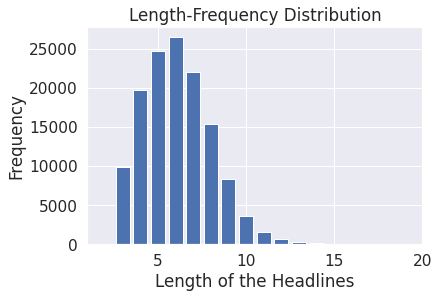

Maximum Length of a headline: 21
Minimum Length of a headline: 3
Average Length of a headline: 6.0


In [9]:
# Calculate the Review of each of the Review
dataset['HeadlineLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.HeadlineLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Headlines')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a headline: {max(dataset.HeadlineLength)}")
print(f"Minimum Length of a headline: {min(dataset.HeadlineLength)}")
print(f"Average Length of a headline: {round(np.mean(dataset.HeadlineLength),0)}")

#Lable Encoding and Dataset Splitting

In [10]:
                                      #==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(category,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        category: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(category)
    encoded_labels = le.transform(category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(category[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(headlines,category):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        headlines: sequenced headlines 
        category: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X,X_test,y,y_test = train_test_split(headlines,category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(headlines),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test


In [11]:
labels = label_encoding(dataset.category,True)


			===== Label Encoding ===== 
Class Names:--> ['Amusement' 'IT' 'International' 'national' 'politics' 'sports']
Amusement   0 

IT   1 

politics   4 

International   2 

International   2 

sports   5 

sports   5 

International   2 

national   3 

International   2 

International   2 

International   2 

International   2 

International   2 

Amusement   0 



In [12]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.headline,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 132713 
	Training		 95552 
	Test			 13272 
	Validation		 23889


#Tokenization

In [13]:
vocab_size = 57000
embedding_dim = 64
max_length = 21
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

def padded_headlines(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(original,"\n",encoded) 
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded)  

In [14]:
# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)


In [15]:
 #============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
না 	 4125
নিয়ে 	 3213
ও 	 3201
নিহত 	 2683
নতুন 	 2288
হবে 	 2193
থেকে 	 2165
বাংলাদেশ 	 1741
সঙ্গে 	 1692
করে 	 1510

Words --> Documents:
না 	 4031
নিয়ে 	 3204
ও 	 3173
নিহত 	 2681
নতুন 	 2273
হবে 	 2182
থেকে 	 2162
বাংলাদেশ 	 1737
সঙ্গে 	 1684
করে 	 1499

Words --> Index:
মিসিসিপিতে 	 55055
ইয়ামেনি 	 55054
ওকিনাওয়ায় 	 55053
শনাক্তকরণের 	 55052
আবিষ্কৃত 	 55051
বেলজীয় 	 55050
পুজদেমনকে 	 55049
‘গান’ 	 55048
বেস 	 55047
ইনস্ট্রুমেন্টাল 	 55046

Total Documents --> 95552
Found 55055 unique tokens


In [16]:
padded_headlines(X_train[10],train_sequences[10],train_padded[10]) 


			====== Encoded Sequences ====== 

মোদির পাশে তৈমুর! 
 [4172, 2216, 6238, 301, 2629, 5925]

			====== Paded Sequences ======
 মোদির পাশে তৈমুর! 
 [4172 2216 6238  301 2629 5925    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


In [17]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_valid[61569],validation_sequences[1],validation_padded[1]) 



			====== Encoded Sequences ====== 

জেলবন্দি তামিলদের মুক্তি দিতে পারেন রাজাপক্ষে 
 [1, 1410, 161, 18585, 4123, 2124, 2521, 2, 851]

			====== Paded Sequences ======
 জেলবন্দি তামিলদের মুক্তি দিতে পারেন রাজাপক্ষে 
 [    1  1410   161 18585  4123  2124  2521     2   851     0     0     0
     0     0     0     0     0     0     0     0     0]


In [18]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
padded_headlines(X_test[100],test_sequences[100],test_padded[100]) 


			====== Encoded Sequences ====== 

দেখতে পারেন শ্রীদেবীর সেরা ৪ ছবি (ভিডিও) 
 [822, 466, 778, 54443]

			====== Paded Sequences ======
 দেখতে পারেন শ্রীদেবীর সেরা ৪ ছবি (ভিডিও) 
 [  822   466   778 54443     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]


In [19]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

#Model Defination

In [20]:
### trying to lstm

keras.backend.clear_session()
accuracy_threshold = 0.97
vocab_size = 57000
embedding_dim = 64
max_length = 21
num_category = 8

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model2.h6"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint] 
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences = True)),
    tf.keras.layers.Bidirectional(LSTM(128)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 64)            3648000   
                                                                 
 bidirectional (Bidirectiona  (None, 21, 256)          197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                6168      
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2

In [21]:
num_epochs = 10
batch = 64
history = model2.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/10
1492/1493 [============================>.] - ETA: 0s - loss: 0.7420 - accuracy: 0.7239
Epoch 1: val_accuracy improved from -inf to 0.81330, saving model to /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6/assets


1493/1493 [==============================] - 58s 32ms/step - loss: 0.7419 - accuracy: 0.7240 - val_loss: 0.5203 - val_accuracy: 0.8133
Epoch 2/10
1491/1493 [============================>.] - ETA: 0s - loss: 0.3553 - accuracy: 0.8747
Epoch 2: val_accuracy improved from 0.81330 to 0.82992, saving model to /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6/assets


1493/1493 [==============================] - 45s 30ms/step - loss: 0.3552 - accuracy: 0.8747 - val_loss: 0.4690 - val_accuracy: 0.8299
Epoch 3/10
1491/1493 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9203
Epoch 3: val_accuracy improved from 0.82992 to 0.83114, saving model to /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/news/Bangla-News-Headlines-Categorization-master/Model2.h6/assets


1493/1493 [==============================] - 50s 33ms/step - loss: 0.2279 - accuracy: 0.9203 - val_loss: 0.5090 - val_accuracy: 0.8311
Epoch 4/10
1493/1493 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9437
Epoch 4: val_accuracy did not improve from 0.83114
1493/1493 [==============================] - 22s 15ms/step - loss: 0.1631 - accuracy: 0.9437 - val_loss: 0.5495 - val_accuracy: 0.8278
Epoch 5/10
1490/1493 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9571
Epoch 5: val_accuracy did not improve from 0.83114
1493/1493 [==============================] - 22s 15ms/step - loss: 0.1212 - accuracy: 0.9571 - val_loss: 0.6179 - val_accuracy: 0.8256
Epoch 6/10
1492/1493 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9672
Epoch 6: val_accuracy did not improve from 0.83114
1493/1493 [==============================] - 22s 15ms/step - loss: 0.0912 - accuracy: 0.9672 - val_loss: 0.6767 - val_accuracy: 0.8199
Epoch 7/10
14

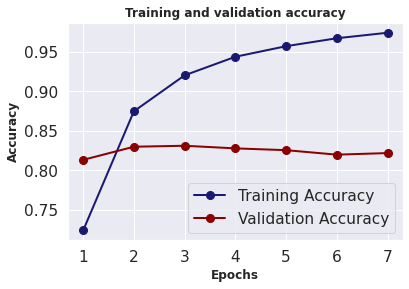

In [22]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, acc, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Training Accuracy')
plt.title('Training and validation accuracy',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Accuracy',fontsize=12,fontweight='bold')
plt.legend(['Training Accuracy','Validation Accuracy'])

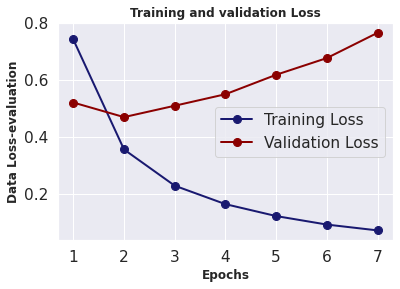

In [23]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')
                  #=========================================================
                  ############### Epochs vs Validation Accuracy Plot ##########
                  #==========================================================

plt.plot(epochs, loss_values, color='midnightblue', linewidth = 2, 
          marker='o', markersize=8,label='Training Loss')
plt.plot(epochs, val_loss_values, color='darkred', linewidth = 2, 
          marker='o', markersize=8,label='Validation Loss')
plt.title('Training and validation Loss',fontsize=12,fontweight='bold')
plt.xlabel('Epochs',fontsize=12,fontweight='bold')
plt.ylabel('Data Loss-evaluation',fontsize=12,fontweight='bold')
plt.legend(['Training Loss','Validation Loss'])

##Confusion Matrix

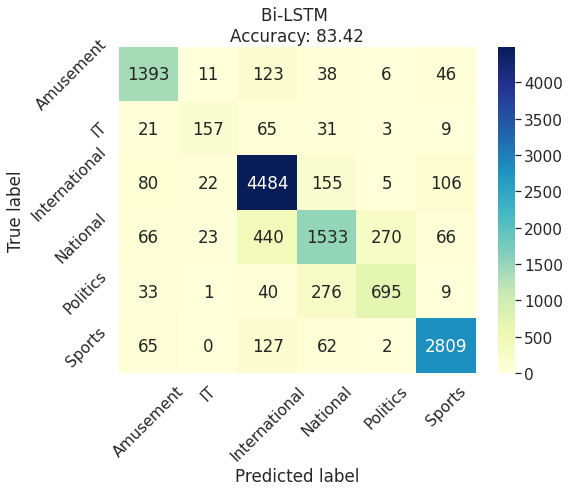

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
model = load_model(path+"Model2.h6")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'], 
                     columns = ['Amusement' ,'IT' ,'International', 'National', 'Politics', 'Sports'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('Bi-LSTM \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [25]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Amusement','1':'IT','2':'International','3':'National','4':'Politics','5':'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
Amusement,84.02,86.15,85.07,1617.000000
IT,73.36,54.90,62.80,286.000000
International,84.94,92.42,88.52,4852.000000
National,73.17,63.93,68.24,2398.000000
Politics,70.85,65.94,68.30,1054.000000
Sports,92.25,91.65,91.95,3065.000000
accuracy,83.42,83.42,83.42,0.834162
macro avg,79.77,75.83,77.48,13272.000000
weighted avg,83.02,83.42,83.07,13272.000000
